<a href="https://colab.research.google.com/github/hiebschi/MoSE_scripts/blob/main/loop_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Segmentation Model

## 1. Preparations
### 1.1 Install required packages

In [1]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 1.2 Install segmentation model

In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4e0d2cd644fa55bad7631eb3a3d98a2f1babd7a7be40279da33c956177b1d01e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=da32785b8ff921098447af9958238ecf717d53dc06bf709c3ea0ba8284788f58
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [4]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Connect my drive to colab

In [6]:
# manual upload (for small files)
# from google.colab import files
# uploaded = files.upload()

In [7]:
# manual upload through Files Tab (right Tab)
!ls /content

sample_data


In [8]:
# ACCESS TO GOOGLE DRIVE
################################################################################
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 1.5 Set data directories

In [9]:
################################################################################
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
################################################################################
# npy preprocessed patches
preprocessed_patches_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/preprocessed_patches'
# JSON class codes
codes_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/classes'
# Shapefile class labels
labels_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/shapefiles'
# npy Masks
masks_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/masks'

#########################
# output directory for trained models
saved_model_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/saved_models'

### 1.6 Check the data

1. Class labels and codes

In [10]:
# Load class labels
################################################################################
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [11]:
# Load class codes
################################################################################
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [12]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

2. Preprocessed patches

In [13]:
################################################################################
# Load preprocessed patches
################################################################################

# list of all .npz-files (.npz-compression)
################################################################################
patches_npz_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npz')]
patches_npz_list.sort()
patches_npz_list[0:3]

['A01_patch_0.npy.npz', 'A01_patch_1.npy.npz', 'A01_patch_10.npy.npz']

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: -0.5852690845132008
Minimum value: -2.1179039301310043
Maximum value: 2.273986928104575
Minimum and maximum after normalization: 0.0 & 1.0


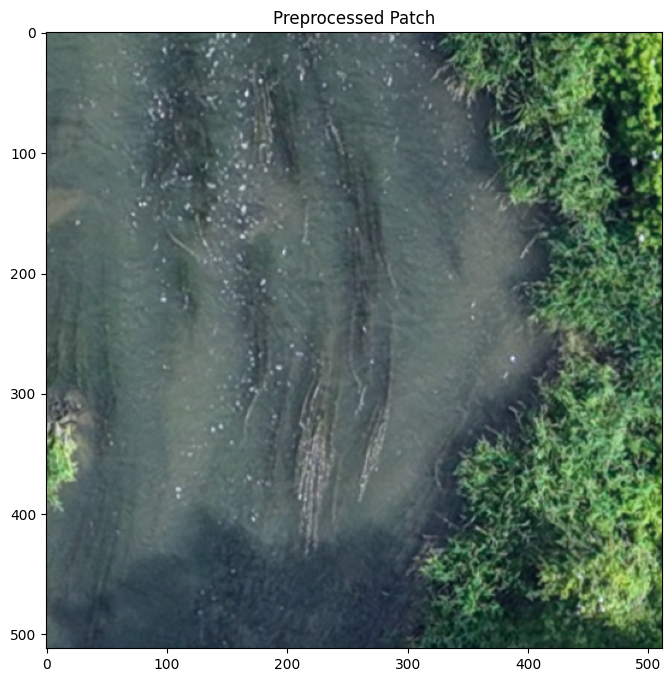

In [14]:
# Test preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 16 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy.npz"

# load npz-file
test_patch_npz = np.load(test_patch_path)
# print(test_pre_patch_npz)

# undo the .npz-compression by extracting the first array
for array in test_patch_npz.files:
  # print(array)
  # extract image data (first array)
  test_patch = test_patch_npz[array]

  # Show properties of the patch
  print("Shape of the patches:", test_patch.shape)
  print("Datatype:", test_patch.dtype)
  print("Type:", type(test_patch))
  print("Mean:", np.mean(test_patch))
  print("Minimum value:", np.min(test_patch))
  print("Maximum value:", np.max(test_patch))

# Normalization of the image data
test_patch_normalized = test_patch - np.min(test_patch ) # set minimum to 0
test_patch_normalized = test_patch_normalized / np.max(test_patch_normalized)  # maximize to 1
print("Minimum and maximum after normalization:", np.min(test_patch_normalized), "&", np.max(test_patch_normalized))

# Plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_patch_normalized.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed Patch")
plt.show()

3. Masks

In [15]:
################################################################################
# Load masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
# masks_list

Shape of the mask: (9, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


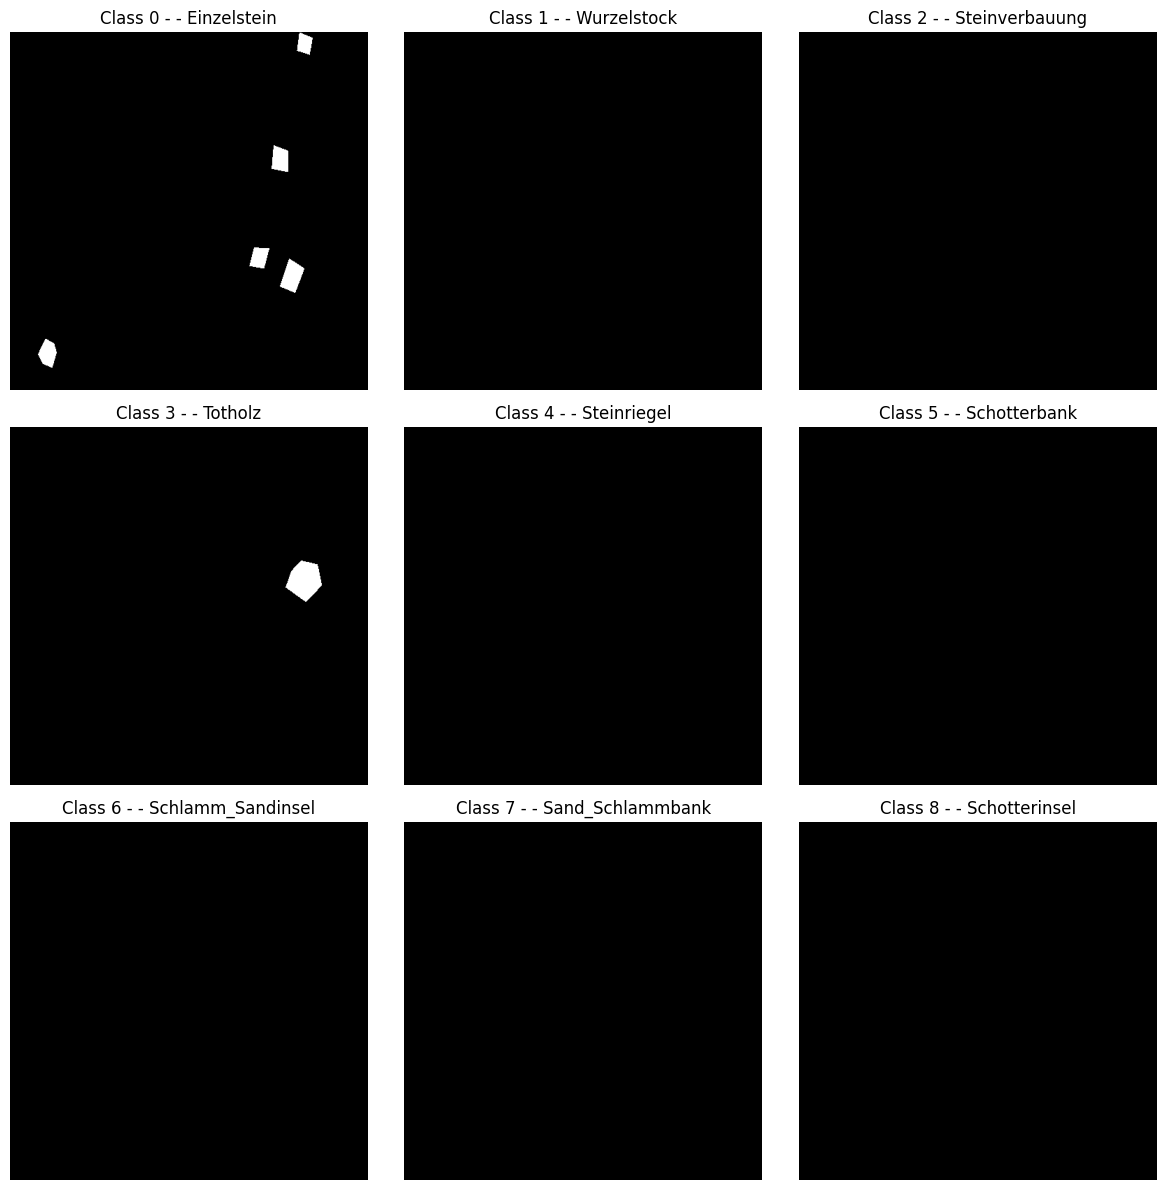

In [16]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 96 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 9 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Splitting data into training and test datasets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# pre_patches_list
# masks_list

In [19]:
# helper-function in order to extract section and patch_id
def extract_section_and_id(file_name):
    parts = file_name.split("_") # split condition: _
    section = parts[0]  # extract section from file_name, e.g. "A01"
    patch_id = parts[2].replace(".npy.npz", "").replace("_mask", "") #  extract patch_id, e.g. 481
    return section, patch_id

In [20]:
# print section and patch_id from masks and patches
print(extract_section_and_id(masks_list[1]))
print(extract_section_and_id(patches_npz_list[175]))

('A01', '103')
('A01', '256')


In [21]:
# group patches by section
section_patches = {} # empty dictionary
for patch in patches_npz_list: # iterate over all preprocessed patches
    section, patch_id = extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

In [22]:
print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08'])


In [23]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################
### HYPERPARAMETER ### -------------------->> ADJUSTABLE
TRAIN_SECTIONS = ["A01", "A02", "A03", "A04", "A05", "A08"]  # Train sections
TEST_SECTIONS = ["A06", "A07"]  # Validation/Test sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in TRAIN_SECTIONS: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in TEST_SECTIONS:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")

Training Patches: 8130
Test Patches: 3043


In [24]:
train_data[8]

'A01_patch_105.npy.npz'

In [25]:
# helper-function to determine whether or not a patch has a corresponding mask
def has_mask(patch_name, masks_dir):

    """ Check if a patch has a corresponding mask in the masks directory.

    Args:
        patch_name (str): Name of the patch (e.g., 'A01_patch_481.npy.npz').
        masks_dir (str): Directory where masks are stored.
    """

    mask_path = os.path.join(masks_dir, patch_name.replace(".npy.npz", "_mask.npy")) # load corresponding mask path
    return os.path.exists(mask_path) # check if path exists

# test helper-function
has_mask(train_data[8], masks_dir)

True

In [26]:
# Separate training and test patches according to whether they have a corresponding mask into label patches and background patches
train_with_masks = [f for f in train_data if has_mask(f, masks_dir)]
# print(train_with_masks)
train_background = [f for f in train_data if not has_mask(f, masks_dir)]
test_with_masks = [f for f in test_data if has_mask(f, masks_dir)]
test_background = [f for f in test_data if not has_mask(f, masks_dir)]

print(f"Training with masks: {len(train_with_masks)}")
print(f"Training background: {len(train_background)}")
print(f"Test with masks: {len(test_with_masks)}")
print(f"Test background: {len(test_background)}")

Training with masks: 2323
Training background: 5807
Test with masks: 724
Test background: 2319


## 3. Dataset and DataLoader

### 3.1 Patch loading functions

In [27]:
# helper-function to load a single .npz file and extract the first array
# function for undoing the .npz-compression! unzip!
def load_npz_patch(patch_npz_name, patches_npz_dir):

    """ Load patch .npz file and undo the .npz compression by extracting the first array and returning it as npy-array.

    Args:
        patch_npz_name (str): Name of the patch .npz file.
        patches_npz_dir (str): Directory where patch .npz files are stored.
    """

    patch_npz_path = os.path.join(patches_npz_dir, patch_npz_name) # path to .npz-file

    try:
        with np.load(patch_npz_path, mmap_mode='r') as data:  # Load the patch .npz-file
        # use memory mapping (mmap_mode='r') for more efficient loading
        # (without loading the total content into RAM)

            array_keys = list(data.keys())  # Get all keys (array names)

            if len(array_keys) > 1:  # Print a warning if multiple arrays are present
                print(f".npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}")

            patch_name = patch_npz_name.replace(".npz", "")  # Remove '.npz' to get the base name

            patch_image = data[array_keys[0]]  # Extract the first array


            return (patch_name, patch_image)

    except Exception as e:  # Handle any errors during file loading
        print(f"Error loading {patch_npz_name}: {e}")
        return None

In [28]:
from concurrent.futures import ThreadPoolExecutor

# Parallel .npz load function
def parallel_load_npz(patches_npz_list, patches_npz_dir):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda fname: load_npz_patch(fname, patches_npz_dir), patches_npz_list))
    return [res for res in results if res is not None]  # Filter out failed loads

### 3.2 Dataset

In [29]:
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, patches_npz_list, patches_npz_dir, masks_dir=None, transform=None, preload = False): # initializes the dataset by saving list of .npz-patches, the directory of the .npz-patches and the masks and optional transformations and preloads

        """
        Custom Dataset for loading .npz patches and optional masks.
        Args:
            patches_npz_list (list): List of the patch .npz-files.
            patches_npz_dir (str): Directory containing patch .npz-files.
            masks_dir (str): Directory containing mask.npy files (optional).
            transform (callable, optional): Transformation to be applied to the data.
            preload (bool): Whether to preload all patches into memory.
        """

        self.patches_npz_list = patches_npz_list
        self.patches_npz_dir = patches_npz_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.preload = preload

        if preload:
            # Parallel loading of patches using ThreadPoolExecutor
            print("Preloading patches...")
            self.preloaded_patches = parallel_load_npz(patches_npz_list, patches_npz_dir)
        else:
            self.preloaded_patches = None

    def __len__(self):

        """
        Returns the number of .npz-patches in the dataset.
        """

        return len(self.patches_npz_list) # returns the number of .npz-patches for the DataLoader

    def __getitem__(self, idx): # loads patch and corresponding mask

        """
        Returns the patch and its corresponding mask.

        Args:
            idx (int): Index of the patch in the dataset.
        Returns:
            tuple: A tuple containing the patch and its mask.
        """

        if self.preload and self.preloaded_patches is not None:
            # Use preloaded patch
            patch_name, patch = self.preloaded_patches[idx] # save patch name and patch image data
        else:
            # Load .npz-patch dynamically with patch loading function (see 4.1)
            patch_name, patch = load_npz_patch(self.patches_npz_list[idx], self.patches_npz_dir) # save patch name and patch image data

        # Convert patch into Tensor and change dtype to float32
        patch = torch.tensor(patch, dtype=torch.float32)

        # Load the mask if available
        if self.masks_dir:
            mask_path = os.path.join(self.masks_dir, patch_name.replace(".npy", "_mask.npy"))
            if os.path.exists(mask_path):
                mask = np.load(mask_path) # load mask
                mask = torch.tensor(mask, dtype=torch.float32) # convert mask into Tensor and change datatype to float32
            else:
                mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.float32)  # Create default background mask = all pixels in all channels (= classes) are zeros
        else:
            mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.float32)  # Default background mask

        # Apply any transformations if needed
        if self.transform:
            patch, mask = self.transform(patch, mask)

        # Ensure mask has the correct number of channels
        if mask.shape[0] != 9:  # If mask doesn't have 9 channels
          print("WARNING: NOT 9 CHANNELS!")
          mask = mask.unsqueeze(0)  # Add a channel dimension to the beginning to make it (1, H, W)
          mask = mask.repeat(9, 1, 1) # Repeat this along the channel dimension 9 times to get the desired shape (9, H, W)

        return patch_name, patch, mask

In [30]:
# Apply Datasets
# Train datasets
train_dataset = PatchDataset(train_with_masks, preprocessed_patches_dir, masks_dir, preload = False) # with masks
# ATTENTION!: "preload = True" leads to crash because of an overuse of cpu-RAM!

# check properties of the mask dataset:
print("Train dataset with class labels:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print(type(train_dataset[0][0]))
print(train_dataset[0][0])
print(train_dataset[0][1].shape)
print(train_dataset[0][2].shape, "\n")

train_background_dataset = PatchDataset(train_background, preprocessed_patches_dir) # background

# check properties of the background dataset:
print("Train dataset without any class labels = background:\n")
print("Type of dataset:", type(train_background_dataset))
print("Number of patches:", len(train_background_dataset))
print(type(train_background_dataset[0][0]))
print(train_background_dataset[0][0])
print(train_background_dataset[0][1].shape)
print(train_background_dataset[0][2].shape)

# Test datasets
test_dataset = PatchDataset(test_with_masks, preprocessed_patches_dir, masks_dir) # with masks
test_background_dataset = PatchDataset(test_background, preprocessed_patches_dir) # background

Train dataset with class labels:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 2323
<class 'str'>
A01_patch_0.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512]) 

Train dataset without any class labels = background:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 5807
<class 'str'>
A01_patch_10.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512])


### 3.3 DataLoader

Right now our data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into a model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [31]:
# Set batch size
# HYPERPARAMETER
##############################
BATCH_SIZE = 4 # -------------------->> ADJUSTABLE
##############################

In [32]:
from torch.utils.data import DataLoader

# Combine Masked and Background datasets into one DataLoader

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)
train_background_loader = DataLoader(train_background_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_background_loader = DataLoader(test_background_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Number of Training Background Batches: {len(train_background_loader)}")
print(f"Number of Test Batches: {len(test_loader)}")
print(f"Number of Test Background Batches: {len(test_background_loader)}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7aab1854b190>
Number of Training Batches: 581 = up to 2324 patches
Number of Training Background Batches: 1452
Number of Test Batches: 181
Number of Test Background Batches: 580


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 3.4 Data exploration

In [33]:
# Explore one batch of data in train_loader
for batch_idx, (names, images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
    print(f"Names - fourth (last) patch name of the batch: {names[3]}", "\n------------")
    print(f"Image type: {type(images)}")
    print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
    print(f"Image excerpt of the fourth patch: {images[3,:,:4,:4]}")
    print(f"Images dtype: {images.dtype}", "\n------------")
    print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
    print(f"Mask excerpt of the mask of the fourth patch: {masks[3,:,:2,:2]}")
    print(f"Masks dtype: {masks.dtype}")
    break

Batch 1: 
------------
------------
Names - fourth (last) patch name of the batch: A05_patch_1077.npy 
------------
Image type: <class 'torch.Tensor'>
Images shape: torch.Size([4, 3, 512, 512])
Image excerpt of the fourth patch: tensor([[[0.1426, 0.0741, 0.0569, 0.0741],
         [0.0912, 0.0741, 0.0398, 0.0569],
         [0.1083, 0.1083, 0.0912, 0.0741],
         [0.1426, 0.1426, 0.1254, 0.0912]],

        [[0.2927, 0.2402, 0.2052, 0.2052],
         [0.2402, 0.2052, 0.1877, 0.2052],
         [0.2577, 0.2227, 0.2227, 0.2402],
         [0.2752, 0.2577, 0.2577, 0.2577]],

        [[0.4439, 0.4091, 0.3916, 0.4091],
         [0.4091, 0.3916, 0.3916, 0.3916],
         [0.4091, 0.4091, 0.4091, 0.4091],
         [0.4439, 0.4439, 0.4265, 0.4265]]])
Images dtype: torch.float32 
------------
Masks shape: torch.Size([4, 9, 512, 512])
Mask excerpt of the mask of the fourth patch: tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],


In [34]:
# Check if there are any labels of class "Totholz" in one batch in the train_loader
for batch_idx, batch in enumerate(train_loader):
    patch_names, images, masks = batch

    # extract mask for class 4 "Totholz"
    class_4_mask = masks[:, 3, :, :]
    print(class_4_mask.shape, "\n") # [batch_size (number of patches), height, width]

    # test if there are any labels for class 4 "Totholz"
    has_class_4_labels = (class_4_mask > 0).any().item()

    # print batch and if there are any labels for class 4
    print(f"Batch {batch_idx + 1}:")
    print(f"Contains class 4 labels: {has_class_4_labels}")

    # if there are any labels for class 4 in one patch, print the names of the patch
    if has_class_4_labels:
        for i, patch_name in enumerate(patch_names):
            if (class_4_mask[i] > 0).any().item():
                print(f"Patch with class 4 labels: {patch_name}")
    break


torch.Size([4, 512, 512]) 

Batch 1:
Contains class 4 labels: True
Patch with class 4 labels: A04_patch_1305.npy
Patch with class 4 labels: A05_patch_124.npy
Patch with class 4 labels: A04_patch_851.npy
Patch with class 4 labels: A03_patch_1164.npy


## 4. Segmentation model

Unet_ is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use concatenation for fusing decoder blocks with skip connections.

URL: https://smp.readthedocs.io/en/latest/models.html#unet

``class segmentation_models_pytorch.Unet(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None, **kwargs)``


In [35]:
################################################################################
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
).to(device)
################################################################################

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


In [36]:
# show model costruction
# model.to(device)

In [37]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [38]:
next(model.parameters()).device

device(type='cuda', index=0)

**Test what the model does with a dummy tensor**

1. do the forward pass >> model outputs raw logits
2. make predictions = turn these logits into prediction labels

In [117]:
# Create a dummy tensor with the same shape as our patches/ image data
dummy_x = torch.rand([1, 3, 512, 512])
print(f"Input shape of our image tensors: {dummy_x.shape} = [batch_size, color channels (RGB), height, width] = patches!")

Input shape of our image tensors: torch.Size([1, 3, 512, 512]) = [batch_size, color channels (RGB), height, width] = patches!


In [119]:
# Do the forward pass and recieve raw logits
with torch.inference_mode():
  dummy_logits = model(dummy_x.to(device))
print(f"Shape of the output of the model = logits: {dummy_logits.shape}")
print(f"Extreme values of the logits: Min: {dummy_logits.min()}, Max: {dummy_logits.max()}")
dummy_logits[0,:,:2,:2]

Shape of the output of the model = logits: torch.Size([1, 9, 512, 512])
Extreme values of the logits: Min: -9.142539024353027, Max: 6.339959621429443


tensor([[[ 0.2309, -0.0027],
         [ 0.2131,  0.2268]],

        [[-0.0914,  0.0756],
         [-0.3867, -0.1119]],

        [[-0.7491, -0.3794],
         [-0.0643, -0.3561]],

        [[-0.0740, -0.1219],
         [-0.3149, -0.2938]],

        [[ 0.1293, -0.0276],
         [-0.1815,  0.0278]],

        [[-0.2547, -0.2771],
         [-0.6699, -0.6397]],

        [[-0.2422, -0.3653],
         [ 0.3007,  0.4290]],

        [[-0.4125, -0.6064],
         [-0.1957, -0.5053]],

        [[-0.3072,  0.2343],
         [-0.7221, -0.1532]]], device='cuda:0')

In [120]:
# Make predictions
# Use sigmoid activation function on the dummy logits to turn them into prediction probabilities
dummy_pred_probs = torch.sigmoid(dummy_logits)
print(f"Shape of the dummy prediction probabilities: {dummy_pred_probs.shape}")
print(f"Extreme values: Min: {dummy_pred_probs.min()}, Max: {dummy_pred_probs.max()}")
# dummy_pred_probs

Shape of the dummy prediction probabilities: torch.Size([1, 9, 512, 512])
Extreme values: Min: 0.00010700381972128525, Max: 0.9982386827468872


In [121]:
# Calculate the predicted labels (round the prediction probabilities)
dummy_preds = torch.round(dummy_pred_probs)
print(f"Shape of the predicted labels: {dummy_preds.shape}")
print(f"Extreme values: Min: {dummy_preds.min()}, Max: {dummy_preds.max()}")
print(f"Unique values: {dummy_preds.unique()}")
dummy_preds[0,:,:2,:2]

Shape of the predicted labels: torch.Size([1, 9, 512, 512])
Extreme values: Min: 0.0, Max: 1.0
Unique values: tensor([0., 1.], device='cuda:0')


tensor([[[1., 0.],
         [1., 1.]],

        [[0., 1.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 1.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.]]], device='cuda:0')

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [43]:
# Setup loss function
loss_fn = smp.losses.DiceLoss(mode="multilabel")

``segmentation_models_pytorch.losses.constants.MULTILABEL_MODE: str = 'multilabel'``    
**Loss multilabel mode** suppose you are solving multi-label segmentation task. That mean you have **C = 1..N classes which pixels are labeled as 1**, classes are **not mutually exclusive** and **each class have its own channel**, pixels in each channel which are not belong to class labeled as 0. Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W).

In [44]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

Test functionality of the loss function

In [129]:
# Create dummy mask
dummy_mask = torch.zeros([1, 9, 512, 512])
shape = dummy_mask.shape
print(shape)
num_channels_to_modify = 9
channels_to_modify = torch.randperm(shape[1])[:num_channels_to_modify]
for channel in channels_to_modify:
    num_pixels = torch.randint(1, 20000, (1,)).item()  # Zufällige Anzahl an Pixeln
    x_coords = torch.randint(0, shape[2], (num_pixels,))
    y_coords = torch.randint(0, shape[3], (num_pixels,))
    dummy_mask[0, channel, x_coords, y_coords] = 1
print(dummy_mask.unique())
# dummy_mask

torch.Size([1, 9, 512, 512])
tensor([0., 1.])


In [130]:
loss_test = loss_fn(dummy_pred_probs.to(device), dummy_mask.to(device))
print(f"Test loss for one example: {loss_test.item()}")

Test loss for one example: 0.923791766166687


Evaluation metrics

In [131]:
# Calculate accuracy (classification metric)
def accuracy_fn(true_mask, pred_mask):
    """
    Calculates pixel-wise accuracy for segmentation tasks.

    Args:
        true_mask (torch.Tensor): Ground truth labels (shape: [batch_size, class channels, height, width]).
        pred_mask (torch.Tensor): Predicted labels (shape: [batch_size, class channels, height, width]).

    Returns:
        float: Pixel-wise accuracy as a percentage.
    """
    # Flatten the tensors to compute over all pixels
    true_mask = true_mask.view(-1)  # Shape: [total_pixels]
    pred_mask = pred_mask.view(-1)  # Shape: [total_pixels]

    # Calculate the number of correctly classified pixels
    correct = torch.eq(true_mask, pred_mask).sum().item()

    # Calculate the total number of pixels
    total_pixels = true_mask.numel()

    # Compute accuracy
    acc = (correct / total_pixels) * 100
    return acc

In [132]:
def per_class_metrics(pred_mask, true_mask, num_classes):
    for i in range(num_classes):
        class_pred = (pred_mask == i)
        class_true = (true_mask == i)
        dice = 2 * (class_pred & class_true).sum() / ((class_pred | class_true).sum() + 1e-6)
        print(f"Class {i}: Dice = {dice:.4f}")

Test functionality of the accuracy function

In [133]:
print(dummy_mask.numel())
dummy_mask.numel() == 1*9*512*512

2359296


True

In [134]:
acc_test = accuracy_fn(true_mask=dummy_mask.to(device), pred_mask=dummy_preds.to(device))
print(f"Accuracy: {acc_test:.2f}%")

Accuracy: 59.29%


In [135]:
per_class_metrics(dummy_preds.to(device), dummy_mask.to(device), 9)

Class 0: Dice = 1.1722
Class 1: Dice = 0.0770
Class 2: Dice = 0.0000
Class 3: Dice = 0.0000
Class 4: Dice = 0.0000
Class 5: Dice = 0.0000
Class 6: Dice = 0.0000
Class 7: Dice = 0.0000
Class 8: Dice = 0.0000


### 3.2 Creating a Timing function
Timing function to measure the time it takes our model to train!

In [137]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [138]:
# test the function
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device)

Train time on cuda: 0.000 seconds


5.540900019695982e-05

### 4.2 Creating a training loop and training a model on batches of data

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

And since we're computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all.

In [148]:
# PREPARATIONS:

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the manual seed
torch.manual_seed(42)

# Start the timer
train_time_start_on_cpu = timer()


# Create training and testing loop

# Set the number of epochs
#################
# HYPERPARAMETER
EPOCHS = 1 # ---------------------> ADJUSTABLE!
#################

# Go through the epochs
##############
# Epoch loop #
################################################################################
for epoch in tqdm(range(EPOCHS)):
    # print current epoch
    print(f"Epoch: {epoch}\n-------")

    ############################################################################
    ### Training Loop ###
    ############################################################################

    # Put model in training mode
    model.train()

    # Define training loss
    train_loss = 0

    # Additional loop through the (training) batches
    ############################################################################
    for batch, (names, train_images, train_masks) in enumerate(train_loader): # go over every patch and its corresponding mask in this batch

        # Put data to the target device
        train_images, train_masks = train_images.to(device), train_masks.to(device)

        #######################
        # 1. Forward pass
        train_logits = model(train_images)
        # print(train_logits.shape)

        # 2. Calculate loss (per batch)
        train_pred_probs = torch.sigmoid(train_logits)
        loss = loss_fn(train_pred_probs, train_masks)
        # print(loss)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # The optimizer will update a model's parameters once per batch rather than once per epoch!!!
        #########################

        # Print out how many batches have been seen
        if batch % 50 == 0:
            print(f"[Batch {batch}/{len(train_loader)}] Train Loss: {loss.item():.4f}")

        # end of the train batch loop
        ########################################################################
    # back in the epoch loop


    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    print(f"Added up train loss: {train_loss}")
    print(f"Length of train_loader: {len(train_loader)}")
    train_loss /= len(train_loader)
    print(f"Average train loss per batch: {train_loss}")


    # end of training loop
    ############################################################################

    ############################################################################### Testing Loop ###
    ############################################################################

    # Setup variables for accumulatively adding up test loss and accuracy
    test_loss, test_acc = 0, 0

    # Put model into evaluation mode
    model.eval()

    with torch.inference_mode():
      # loop through the (testing) batches
      for names, test_images, test_masks in test_loader: # we do not need keep track of the batches in the test_loader again (because no backpropagation/optimization per batch)

        # Put data to the target device
        test_images, test_masks = test_images.to(device), test_masks.to(device)

        #######################
        # 1. Forward pass
        test_logits = model(test_images).to(device)

        # 2. Calculate loss (accumulatively)
        test_pred_probs = torch.sigmoid(test_logits)
        test_loss += loss_fn(test_pred_probs, test_masks) # accumulatively add up the loss per epoch

        # 3. Calculate accuracy (pred masks need to be same as true masks)
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_acc += accuracy_fn(true_mask=test_masks, pred_mask=test_preds) # compare labels to labels
        #######################

      # Calculations on test metrics need to happen inside torch.inference_mode()
      # Divide total test loss by length of test dataloader (per batch) =  test loss average per batch
      test_loss /= len(test_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      test_acc /= len(test_loader)

      ########################################################################
    # back in the epoch loop

    # METRICS
    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%\n")

################################################################################
# end of the epoch loop


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
  end=train_time_end_on_cpu, device=str(next(model.parameters()).device))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
-------
[Batch 0/581] Train Loss: 0.1070
[Batch 50/581] Train Loss: 0.3271
[Batch 100/581] Train Loss: 0.1050
[Batch 150/581] Train Loss: 0.2185
[Batch 200/581] Train Loss: 0.5338
[Batch 250/581] Train Loss: 0.3209
[Batch 300/581] Train Loss: 0.2176
[Batch 350/581] Train Loss: 0.2116
[Batch 400/581] Train Loss: 0.3147
[Batch 450/581] Train Loss: 0.2205
[Batch 500/581] Train Loss: 0.3291
[Batch 550/581] Train Loss: 0.1067
Added up train loss: 148.81675720214844
Length of train_loader: 581
Average train loss per batch: 0.25613898038864136

Train loss: 0.2561 | Test loss: 0.1586, Test acc: 71.7844%

Train time on cuda:0: 174.112 seconds


### 4.3 Functionizing training and test loop

In [149]:
# # Training Loop
# def train_step(model: torch.nn.Module,
#                data_loader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer,
#                accuracy_fn,
#                device: torch.device = device):

#     """Performs a training loop step with model trying to learn on data_loader."""

#     """
#     Args:
#         model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
#         data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
#         loss_fn (torch.nn.Module): The loss function of model.
#         optimizer (torch.optim.Optimizer): The optimizer to use to optimize the model parameters.
#         accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
#         device (str, optional): Target device to compute on. Defaults to device.
#     """

#     train_loss, train_acc = 0, 0
#     model.to(device)

#     # Put model into training mode
#     model.train()

#     for batch, (names, X, y) in enumerate(data_loader):
#         # Send data to available device
#         X, y = X.to(device), y.to(device)

#         # 1. Forward pass
#         y_pred = model(X)

#         # 2. Calculate loss and accuracy per batch
#         loss = loss_fn(y_pred, y)
#         train_loss += loss
#         train_acc += accuracy_fn(y_true=y,
#                                  y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#     # outside of the for loop
#     # Calculate loss and accuracy per epoch and print out what's happening
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [150]:
# # Testing Loop
# def test_step(data_loader: torch.utils.data.DataLoader,
#               model: torch.nn.Module,
#               loss_fn: torch.nn.Module,
#               accuracy_fn,
#               device: torch.device = device):
#     """Performs a testing loop step with model trying to learn on data_loader."""

#     test_loss, test_acc = 0, 0
#     model.to(device)

#     model.eval() # put model in eval mode
#     # Turn on inference context manager
#     with torch.inference_mode():
#         for names, X, y in data_loader:
#             # Send data to GPU
#             X, y = X.to(device), y.to(device)

#             # 1. Forward pass
#             test_pred = model(X)

#             # 2. Calculate loss and accuracy
#             test_loss += loss_fn(test_pred, y)
#             test_acc += accuracy_fn(y_true=y,
#                 y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
#             )

#         # Adjust metrics and print out
#         test_loss /= len(data_loader)
#         test_acc /= len(data_loader)
#         print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [151]:
# # Use the train_step and test_step functions
# # DO THE TRAINING AND TESTING LOOP
# torch.manual_seed(42)

# # Measure time
# from timeit import default_timer as timer
# train_time_start_on_gpu = timer()

# epochs = 1
# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n---------")
#     train_step(data_loader=train_loader,
#         model=model,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy_fn=accuracy_fn
#     )
#     test_step(data_loader=test_loader,
#         model=model,
#         loss_fn=loss_fn,
#         accuracy_fn=accuracy_fn
#     )

# train_time_end_on_gpu = timer()
# total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
#                                             end=train_time_end_on_gpu,
#                                             device=device)

### 4.4 Evaluate model

In [153]:
# def eval_model(model: torch.nn.Module,
#                data_loader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                accuracy_fn,
#                device = device):

#     """Returns a dictionary containing the results of model predicting on data_loader.

#     Args:
#         model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
#         data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
#         loss_fn (torch.nn.Module): The loss function of model.
#         accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

#     Returns:
#         (dict): Results of model making predictions on data_loader.
#     """

#     loss, acc = 0, 0
#     model.eval()
#     with torch.inference_mode():
#         for name, X, y in tqdm(data_loader):
#             # Make our data device agnostic
#             X, y = X.to(device), y.to(device)

#             # Make predictions with the model
#             y_pred = model(X).to(device)

#             # Accumulate the loss and accuracy values per batch
#             loss += loss_fn(y_pred, y)
#             acc += accuracy_fn(y_true=y,
#                                 y_pred=y_pred.argmax(dim=0)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

#         # Scale loss and acc to find the average loss/acc per batch
#         loss /= len(data_loader)
#         acc /= len(data_loader)

#     return {"model_name": model.__class__.__name__, # only works when model was created with a class
#             "model_loss": loss.item(),
#             "model_acc": acc}

In [154]:
# torch.manual_seed(42)
# # Calculate model results on test dataset
# model_results = eval_model(model=model.to(device), data_loader=test_loader,
#     loss_fn=loss_fn, accuracy_fn=accuracy_fn
# )
# model_results

In [157]:
print(f"Train logits shape: {train_logits.shape} -> [batch_size, num_classes, H, W]")
print(f"Min: {train_logits.min()}, Max: {train_logits.max()}")
# print(y_pred)

train_pred_probs = torch.argmax(train_logits, dim=0)  # shape [batch_size, H, W]

pred_classes.shape, pred_classes.min(), pred_classes.max()


Shape: torch.Size([3, 9, 512, 512]) -> [batch_size, num_classes, H, W]
Min: -19.067800521850586, Max: 25.273365020751953


(torch.Size([9, 512, 512]),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'))

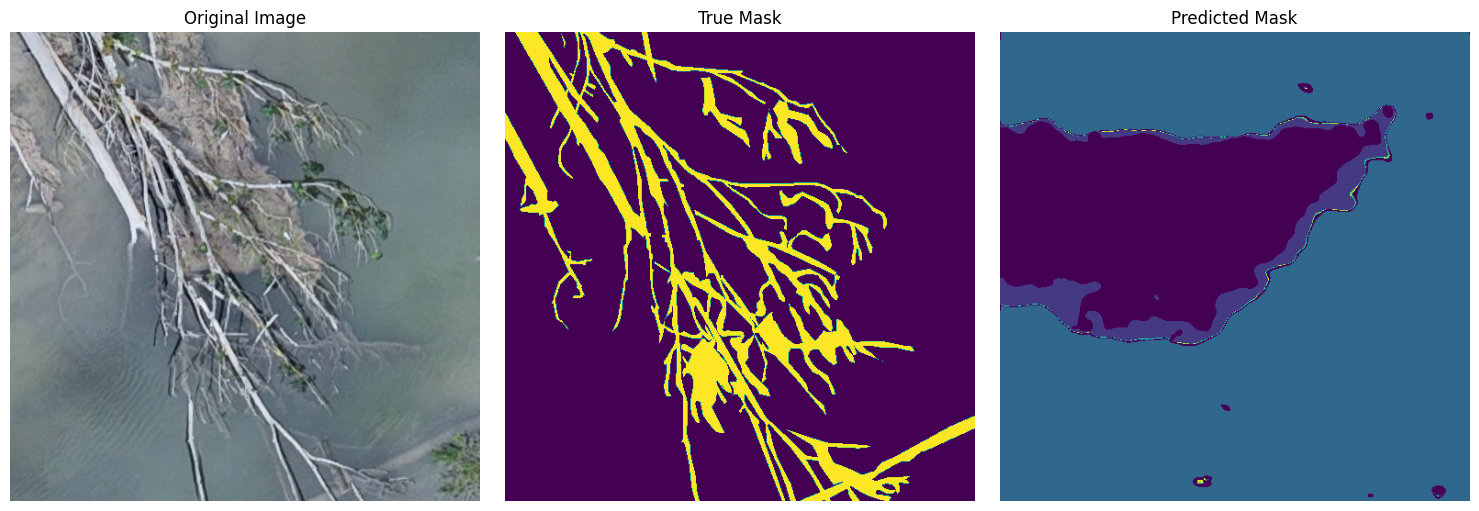

Test loss for example: 0.332133024930954


In [169]:
import matplotlib.pyplot as plt

# Choose one patch (index of a batch)
idx = 1

# RGB patch
image = images[idx].permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
image = (image - image.min()) / (image.max() - image.min())

# True mask (with argmax from [num_classes, H, W] to [H, W])
true_mask = masks[idx].cpu().numpy().argmax(axis=0)  # [H, W]

# Predicted mask (with argmax from [num_classes, H, W] to [H, W])
pred_mask = test_preds[idx].cpu().numpy().argmax(axis=0) # [H, W]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(true_mask, cmap="viridis")
axes[1].set_title("True Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask, cmap="viridis")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

loss = loss_fn(test_pred_probs.to(device), test_masks.to(device))
print(f"Test loss for example: {loss.item()}")

In [ ]:
# def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
#     pred_probs = []
#     model.to(device)
#     model.eval()
#     with torch.inference_mode():
#         for sample in data:
#             # Prepare sample
#             sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

#             # Forward pass (model outputs raw logit)
#             pred_logit = model(sample)

#             # Get prediction probability (logit -> prediction probability)
#             pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

#             # Get pred_prob off GPU for further calculations
#             pred_probs.append(pred_prob.cpu())

#     # Stack the pred_probs to turn list into a tensor
#     return torch.stack(pred_probs)

## 5. Save and load model

Preparations

In [171]:
# Create model name and corresponding path
MODEL_NAME = "test_unet_model_0.pth" # ----------------------> ADJUSTABLE!
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

Save model

In [172]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/saved_models/test_unet_model_0.pth


Load model

In [175]:
# Load model
# Create a new instance of the model (same class as our saved state_dict())
loaded_model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
).to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path))

# Send model to GPU
loaded_model = loaded_model.to(device)

<ipython-input-175-3bc470d72046>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=save_model_path))


Evaluate and test loaded model

In [177]:
# # Evaluate loaded model
# torch.manual_seed(42)

# loaded_model_results = eval_model(
#     model=loaded_model,
#     data_loader=test_loader,
#     loss_fn=loss_fn,
#     accuracy_fn=accuracy_fn
# )

# loaded_model_results

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }